In [1]:
import scanpy as sc
import scvelo as scv
import numpy as np

In [2]:
def pp(path):
    adata = sc.read_10x_mtx(path)
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
    adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
    adata = adata[adata.obs.pct_counts_mt < 20]
    sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
    sc.pp.log1p(adata) #change to log counts
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values
    adata.raw = adata #save raw data before processing values and further filtering
    adata = adata[:, adata.var.highly_variable] #filter highly variable
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
    sc.pp.scale(adata, max_value=10) #scale each gene to unit variance
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
    sc.tl.leiden(adata, resolution = 0.25)
    sc.tl.umap(adata)
    return adata

In [3]:
adata = pp('../tutorial_sample/outs/filtered_feature_bc_matrix/')

In [4]:
ldata = scv.read('../tutorial_sample/velocyto/tutorial_sample.loom')

In [5]:
adata = scv.utils.merge(adata, ldata)

In [6]:
scv.pp.filter_and_normalize(adata)

Normalized count data: spliced, unspliced.


In [7]:
scv.pp.moments(adata)

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [8]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [9]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/24 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [10]:
scv.set_figure_params()

In [11]:
adata.obs

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGGGCAATC     3243               3243        8900.0              5.0   
AAACCCAAGTATAGAC     5443               5443       25977.0           1477.0   
AAACCCACAACGCATT     5159               5159       21172.0           1035.0   
AAACCCACACGCGCAT     5991               5991       26725.0           1724.0   
AAACCCAGTAAGATCA     2599               2599        6490.0            242.0   
...                   ...                ...           ...              ...   
TTTGTTGCACTGTGTA     2215               2215        6958.0             74.0   
TTTGTTGCAGATTTCG     1579               1579        5194.0              9.0   
TTTGTTGGTCGTCTCT     4111               4111       14611.0            631.0   
TTTGTTGGTGTAACGG     2556               2555        9147.0            221.0   
TTTGTTGGTGTCATTG     3539               3539        9469.0            693.0   

                  pct_counts_mt leiden Clusters         _X         _Y  \
AAACCCAAGGGCAATC       0.056180      2        1   9.826839 -19.654728   
AAACCCAAGTATAGAC       5.685799      1        6 -53.409458  -4.331635   
AAACCCACAACGCATT       4.888532      2        0  42.933899  -0.720094   
AAACCCACACGCGCAT       6.450889      2        4  -9.191654   2.027606   
AAACCCAGTAAGATCA       3.728814      2        7  34.793198  21.428041   
...                         ...    ...      ...        ...        ...   
TTTGTTGCACTGTGTA       1.063524      1        0  24.202335 -19.833521   
TTTGTTGCAGATTTCG       0.173277      3        1  14.307149 -14.085862   
TTTGTTGGTCGTCTCT       4.318664      0        2  17.742739  15.241697   
TTTGTTGGTGTAACGG       2.416093      1        7  29.698542  24.854696   
TTTGTTGGTGTCATTG       7.318619      2        3 -12.580539  26.219252   

                  initial_size_spliced  initial_size_unspliced  initial_size  \
AAACCCAAGGGCAATC                  6958                    1153        6958.0   
AAACCCAAGTATAGAC                 18402                    7360       18402.0   
AAACCCACAACGCATT                 15273                    4763       15273.0   
AAACCCACACGCGCAT                 17941                   12123       17941.0   
AAACCCAGTAAGATCA                  4878                     465        4878.0   
...                                ...                     ...           ...   
TTTGTTGCACTGTGTA                  4918                    4538        4918.0   
TTTGTTGCAGATTTCG                  3898                     219        3898.0   
TTTGTTGGTCGTCTCT                 10022                    7052       10022.0   
TTTGTTGGTGTAACGG                  6472                    4156        6472.0   
TTTGTTGGTGTCATTG                  6771                    3225        6771.0   

                    n_counts  velocity_self_transition  
AAACCCAAGGGCAATC  249.634338                  0.141427  
AAACCCAAGTATAGAC -410.603882                  0.243409  
AAACCCACAACGCATT  246.062408                  0.309066  
AAACCCACACGCGCAT  -17.365356                  0.232311  
AAACCCAGTAAGATCA  -48.000458                  0.183199  
...                      ...                       ...  
TTTGTTGCACTGTGTA -224.875885                  0.149878  
TTTGTTGCAGATTTCG -846.695923                  0.121273  
TTTGTTGGTCGTCTCT    9.776880                  0.132265  
TTTGTTGGTGTAACGG -235.443161                  0.109832  
TTTGTTGGTGTCATTG  219.139893                  0.260213  

[7918 rows x 14 columns]

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


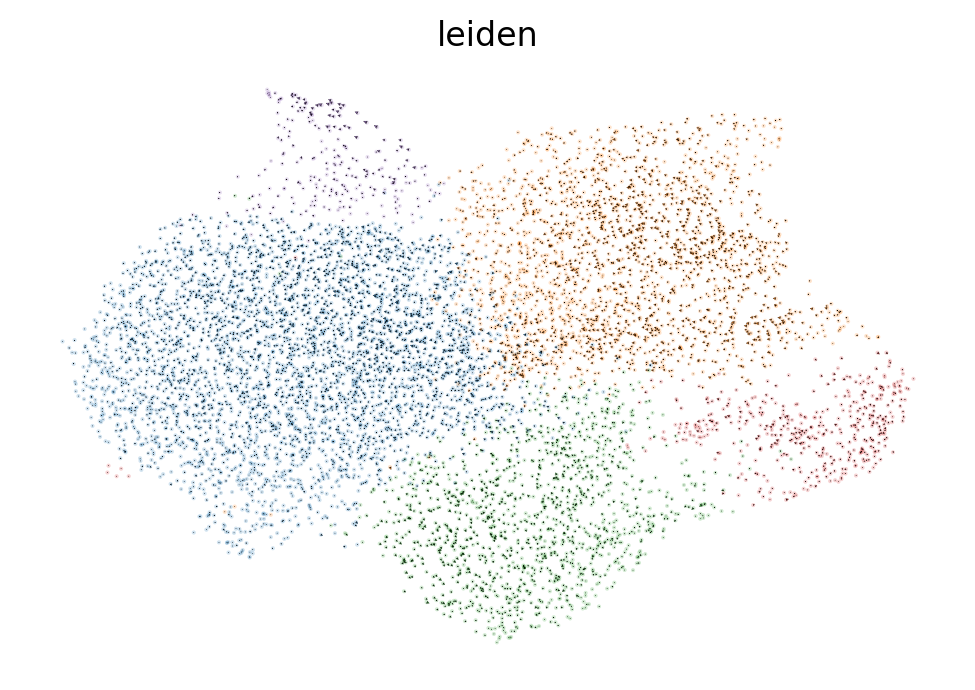

In [13]:
scv.pl.velocity_embedding(adata, basis = 'umap', color = 'leiden')

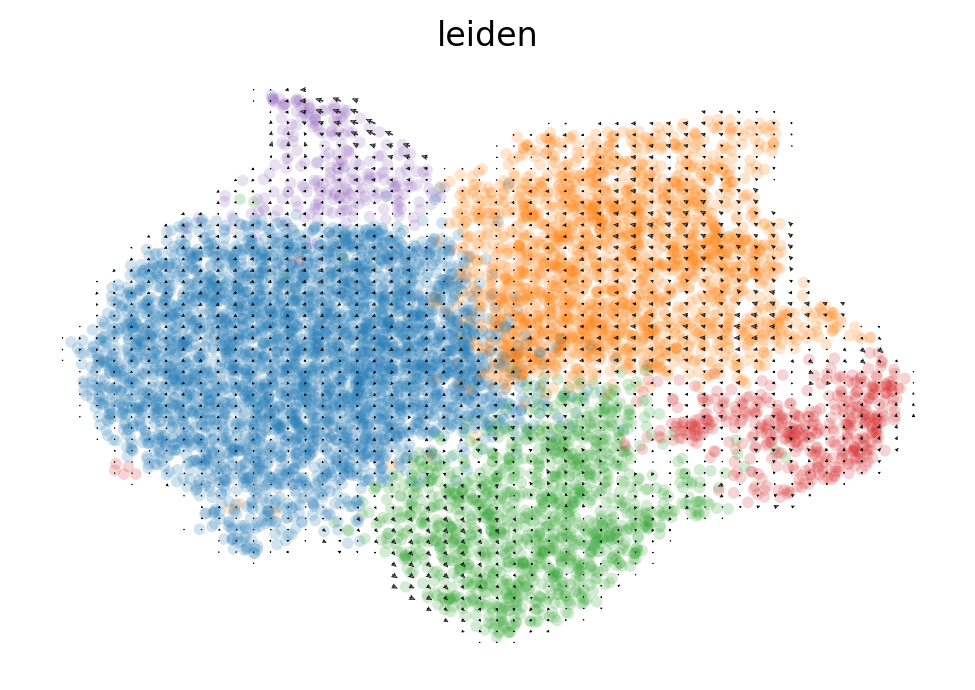

In [14]:
scv.pl.velocity_embedding_grid(adata, basis = 'umap', color = 'leiden')

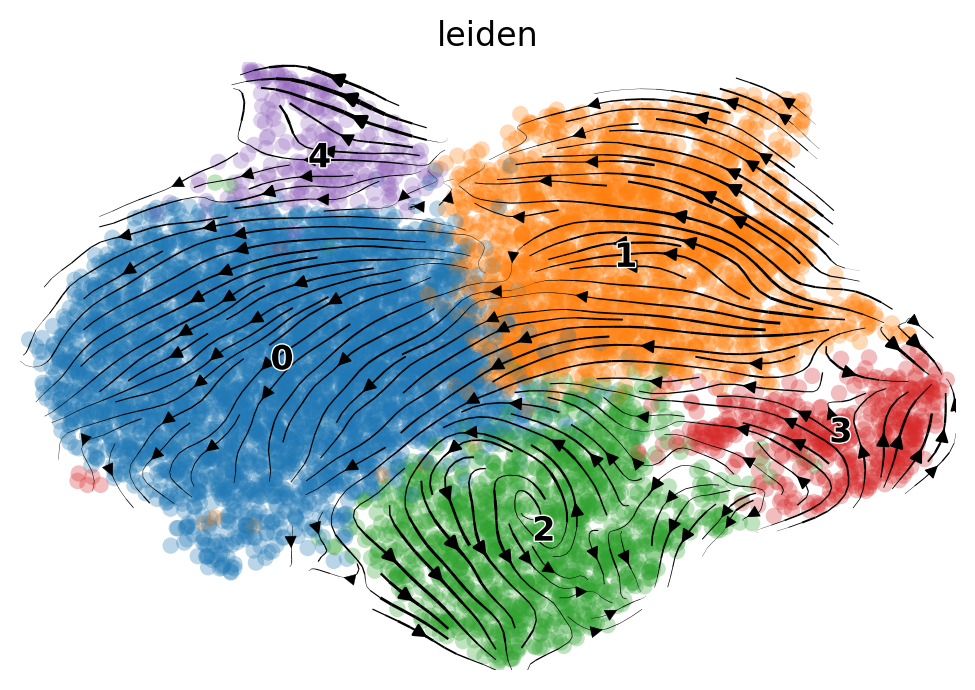

In [15]:
scv.pl.velocity_embedding_stream(adata, basis = 'umap', color = 'leiden')

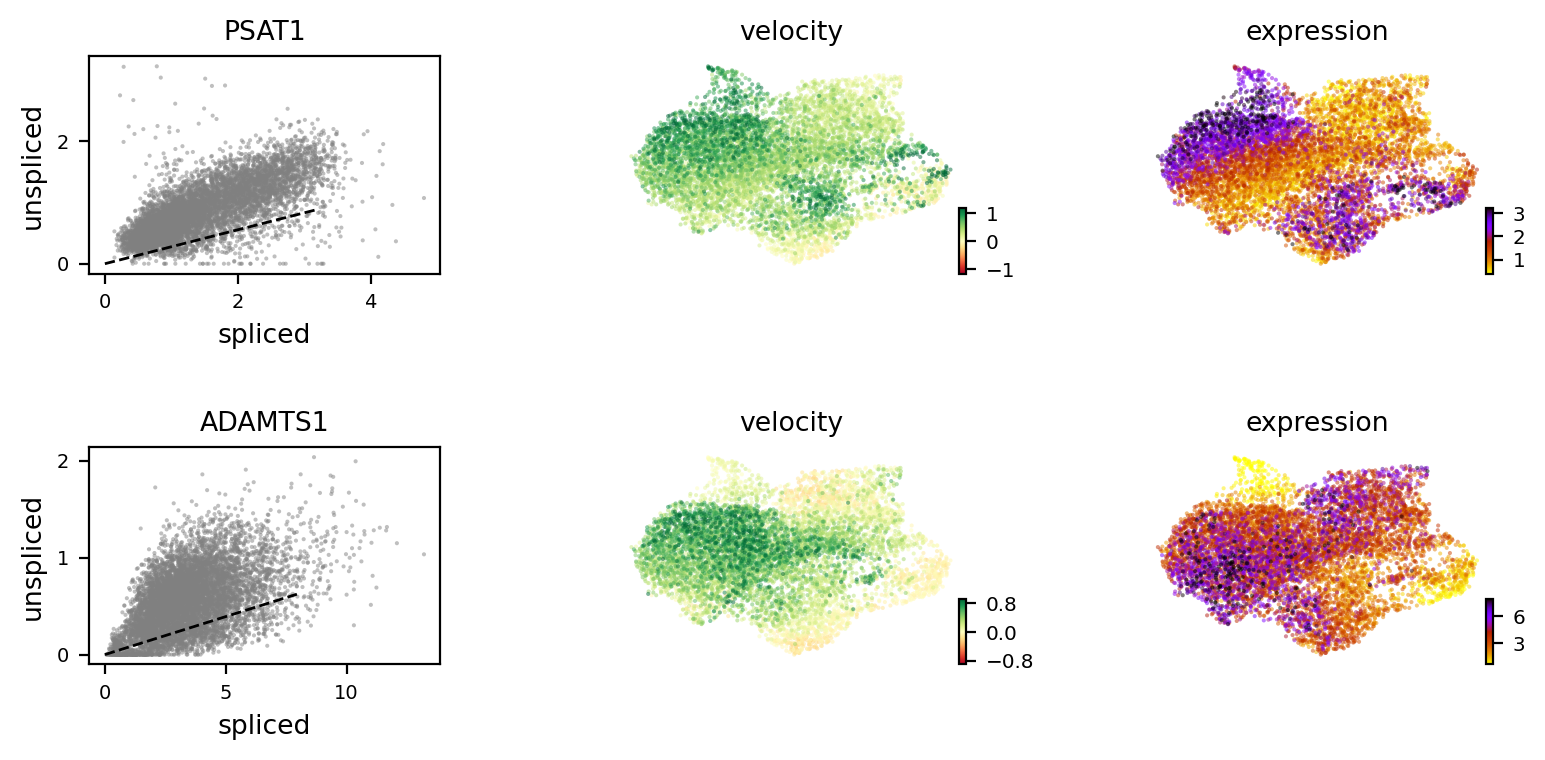

In [17]:
scv.pl.velocity(adata, ['PSAT1', 'ADAMTS1'])

In [19]:
scv.tl.rank_velocity_genes(adata, groupby = 'leiden', min_corr=0.3)

ranking velocity genes
    finished (0:00:05) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [20]:
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

0          1       2       3          4
0  ADAMTS1  LINC02680    PIF1    NEFM      PSAT1
1     FOSB     RNF138    ASPM   CENPF       OASL
2     AMOT    TSC22D2  GAS2L3   CCNB1       ELOA
3      CA2       RBPJ    SGO2   CENPA  LINC02680
4      FOS       TPX2    NEFM  DEPDC1       AMOT

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)


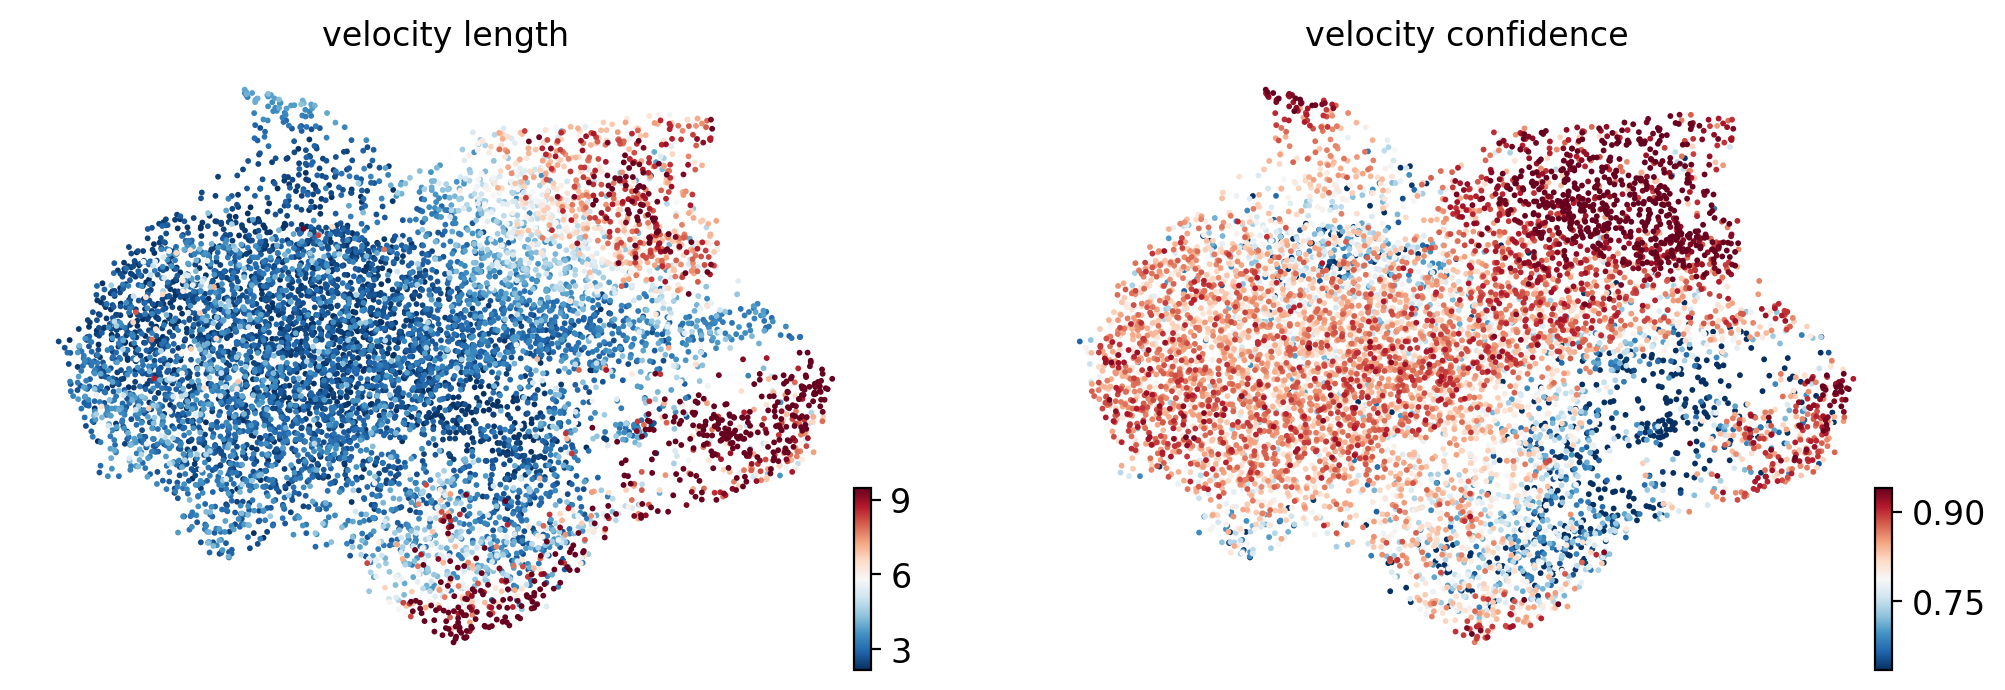

In [22]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c = keys, perc = [5,95])

In [23]:
adata.obs

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGGGCAATC     3243               3243        8900.0              5.0   
AAACCCAAGTATAGAC     5443               5443       25977.0           1477.0   
AAACCCACAACGCATT     5159               5159       21172.0           1035.0   
AAACCCACACGCGCAT     5991               5991       26725.0           1724.0   
AAACCCAGTAAGATCA     2599               2599        6490.0            242.0   
...                   ...                ...           ...              ...   
TTTGTTGCACTGTGTA     2215               2215        6958.0             74.0   
TTTGTTGCAGATTTCG     1579               1579        5194.0              9.0   
TTTGTTGGTCGTCTCT     4111               4111       14611.0            631.0   
TTTGTTGGTGTAACGG     2556               2555        9147.0            221.0   
TTTGTTGGTGTCATTG     3539               3539        9469.0            693.0   

                  pct_counts_mt leiden Clusters         _X         _Y  \
AAACCCAAGGGCAATC       0.056180      2        1   9.826839 -19.654728   
AAACCCAAGTATAGAC       5.685799      1        6 -53.409458  -4.331635   
AAACCCACAACGCATT       4.888532      2        0  42.933899  -0.720094   
AAACCCACACGCGCAT       6.450889      2        4  -9.191654   2.027606   
AAACCCAGTAAGATCA       3.728814      2        7  34.793198  21.428041   
...                         ...    ...      ...        ...        ...   
TTTGTTGCACTGTGTA       1.063524      1        0  24.202335 -19.833521   
TTTGTTGCAGATTTCG       0.173277      3        1  14.307149 -14.085862   
TTTGTTGGTCGTCTCT       4.318664      0        2  17.742739  15.241697   
TTTGTTGGTGTAACGG       2.416093      1        7  29.698542  24.854696   
TTTGTTGGTGTCATTG       7.318619      2        3 -12.580539  26.219252   

                  initial_size_spliced  initial_size_unspliced  initial_size  \
AAACCCAAGGGCAATC                  6958                    1153        6958.0   
AAACCCAAGTATAGAC                 18402                    7360       18402.0   
AAACCCACAACGCATT                 15273                    4763       15273.0   
AAACCCACACGCGCAT                 17941                   12123       17941.0   
AAACCCAGTAAGATCA                  4878                     465        4878.0   
...                                ...                     ...           ...   
TTTGTTGCACTGTGTA                  4918                    4538        4918.0   
TTTGTTGCAGATTTCG                  3898                     219        3898.0   
TTTGTTGGTCGTCTCT                 10022                    7052       10022.0   
TTTGTTGGTGTAACGG                  6472                    4156        6472.0   
TTTGTTGGTGTCATTG                  6771                    3225        6771.0   

                    n_counts  velocity_self_transition  velocity_length  \
AAACCCAAGGGCAATC  249.634338                  0.141427             5.66   
AAACCCAAGTATAGAC -410.603882                  0.243409             3.17   
AAACCCACAACGCATT  246.062408                  0.309066             7.25   
AAACCCACACGCGCAT  -17.365356                  0.232311             2.83   
AAACCCAGTAAGATCA  -48.000458                  0.183199             7.05   
...                      ...                       ...              ...   
TTTGTTGCACTGTGTA -224.875885                  0.149878            11.28   
TTTGTTGCAGATTTCG -846.695923                  0.121273            11.54   
TTTGTTGGTCGTCTCT    9.776880                  0.132265             2.81   
TTTGTTGGTGTAACGG -235.443161                  0.109832             4.80   
TTTGTTGGTGTCATTG  219.139893                  0.260213             3.13   

                  velocity_confidence  velocity_confidence_transition  
AAACCCAAGGGCAATC             0.762295                        0.775571  
AAACCCAAGTATAGAC             0.607477                        0.105437  
AAACCCACAACGCATT             0.863713                        0.358121  
AAACCCACACGCGCAT             0.718722     

computing terminal states
    identified 5 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


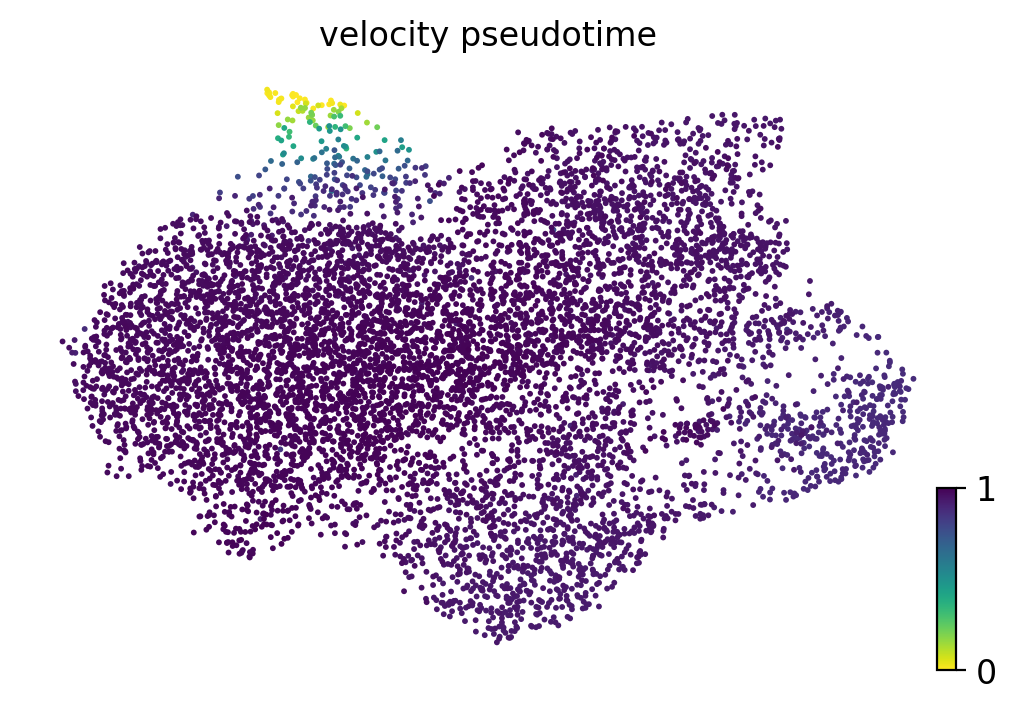

In [24]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color = 'velocity_pseudotime')

recovering dynamics (using 20/24 cores)
    finished (0:00:28) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


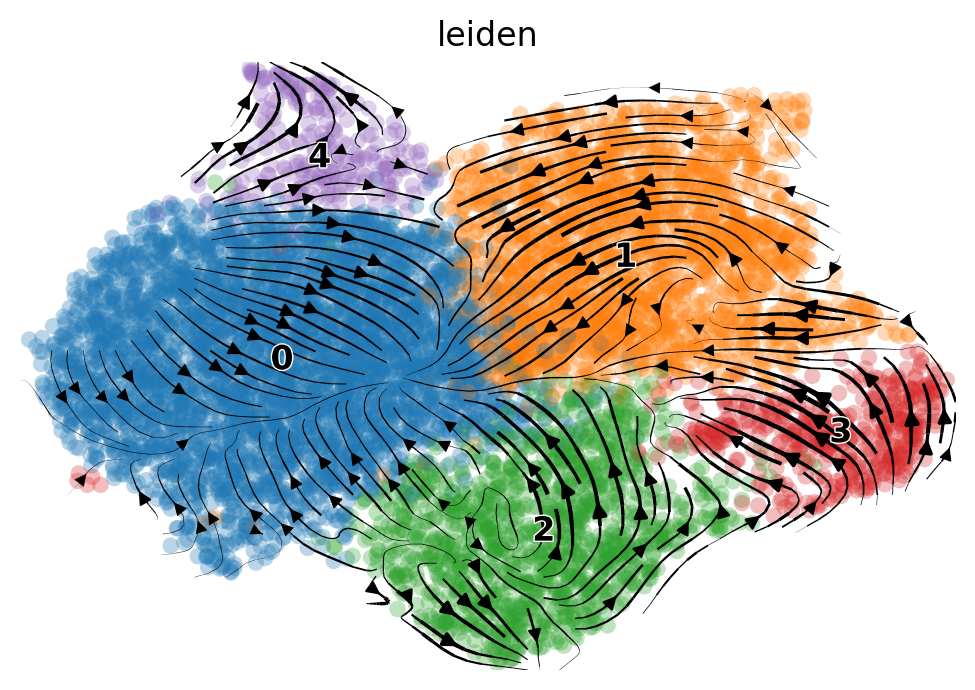

In [25]:
scv.tl.recover_dynamics(adata, n_jobs = 20)
scv.tl.velocity(adata, mode = 'dynamical')
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis = 'umap', color = 'leiden')

computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


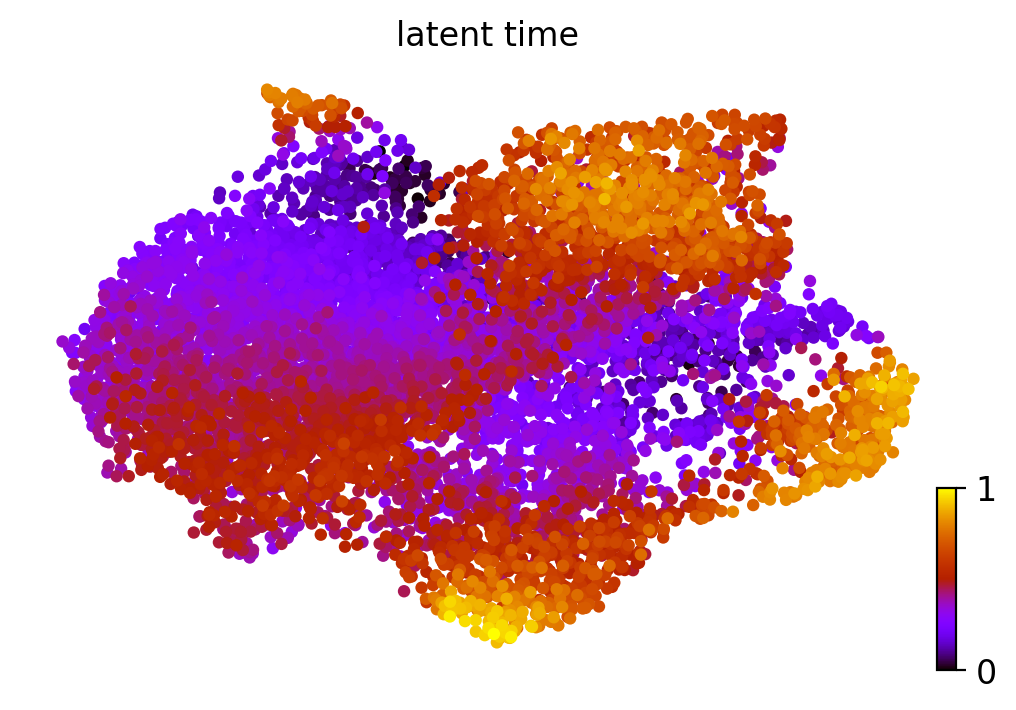

In [28]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color = 'latent_time', color_map = 'gnuplot', size = 80)

In [29]:
test = scv.datasets.pancreas()

In [30]:
test

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [31]:
scv.pp.filter_and_normalize(test)
scv.pp.moments(test)
scv.tl.velocity(adata, mode='stochastic')

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [32]:
scv.tl.velocity_graph(test)

computing velocities
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)
    finished (0:00:17) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


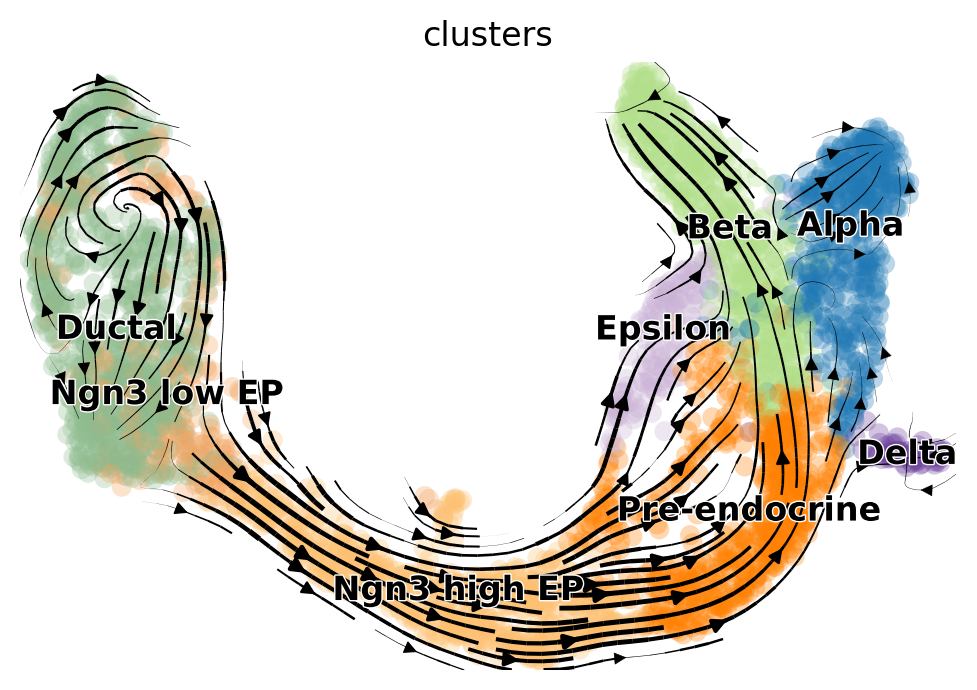

In [34]:
scv.pl.velocity_embedding_stream(test, basis='umap', color = 'clusters')

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


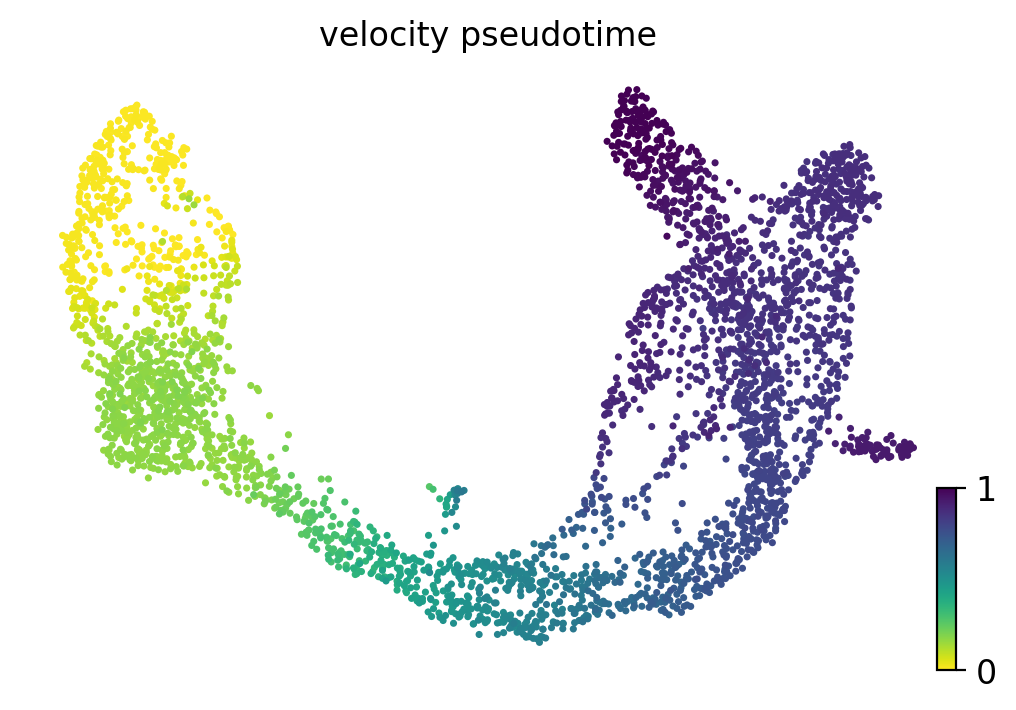

In [36]:
scv.tl.velocity_pseudotime(test)
scv.pl.scatter(test, color = 'velocity_pseudotime')

recovering dynamics (using 20/24 cores)
    finished (0:03:08) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:12) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)
    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


ValueError: color key is invalid! pass valid observation annotation or a gene name

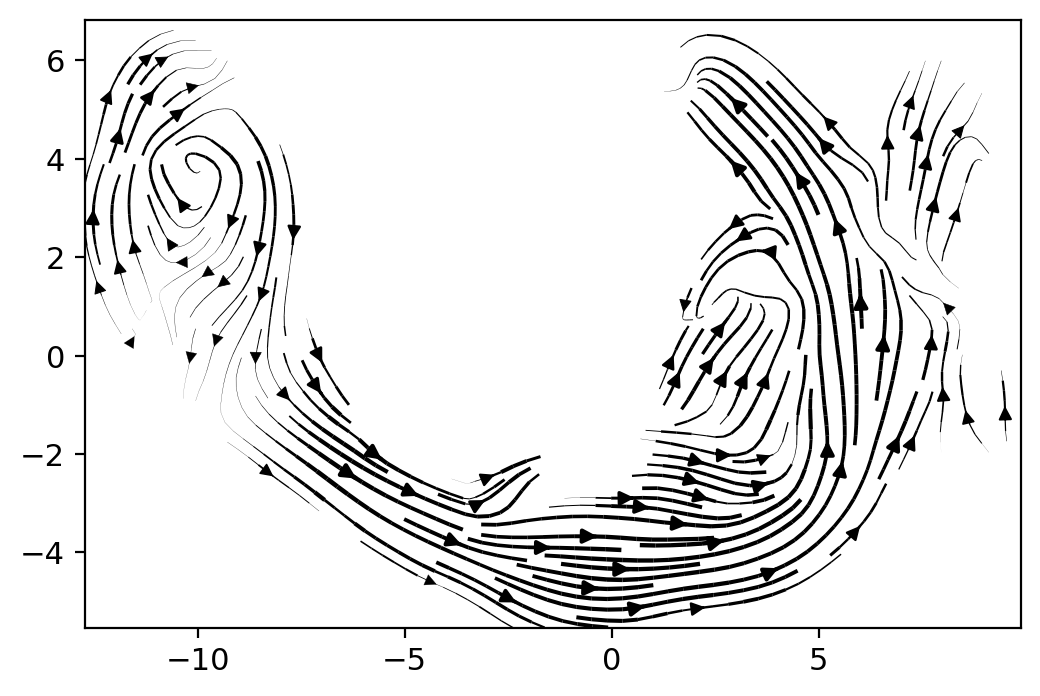

In [37]:
scv.tl.recover_dynamics(test, n_jobs = 20)
scv.tl.velocity(test, mode = 'dynamical')
scv.tl.velocity_graph(test)

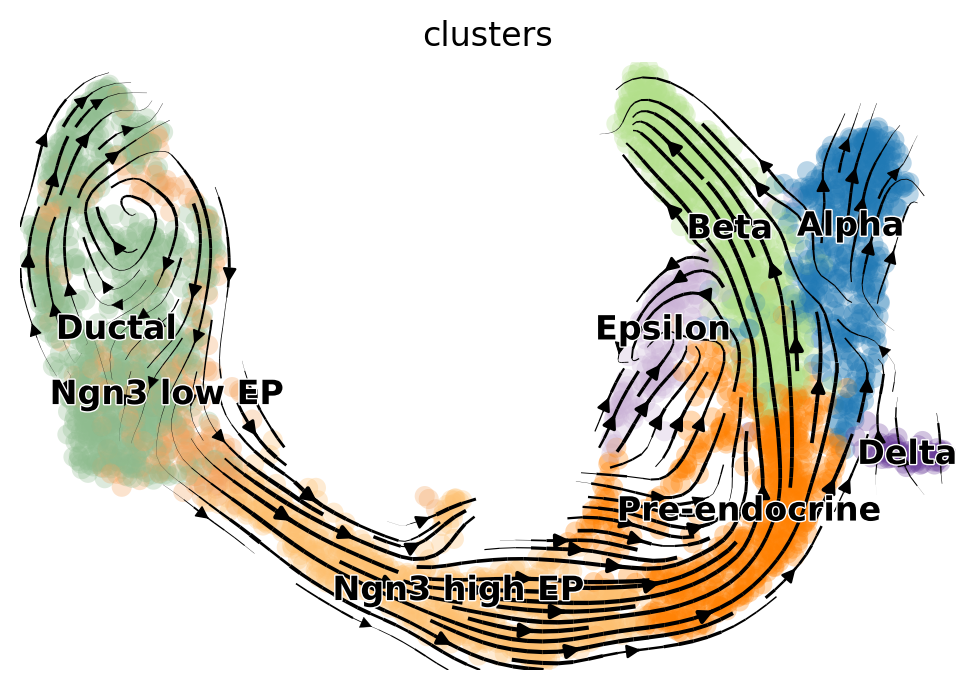

In [38]:
scv.pl.velocity_embedding_stream(test, basis = 'umap', color = 'clusters')

computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)


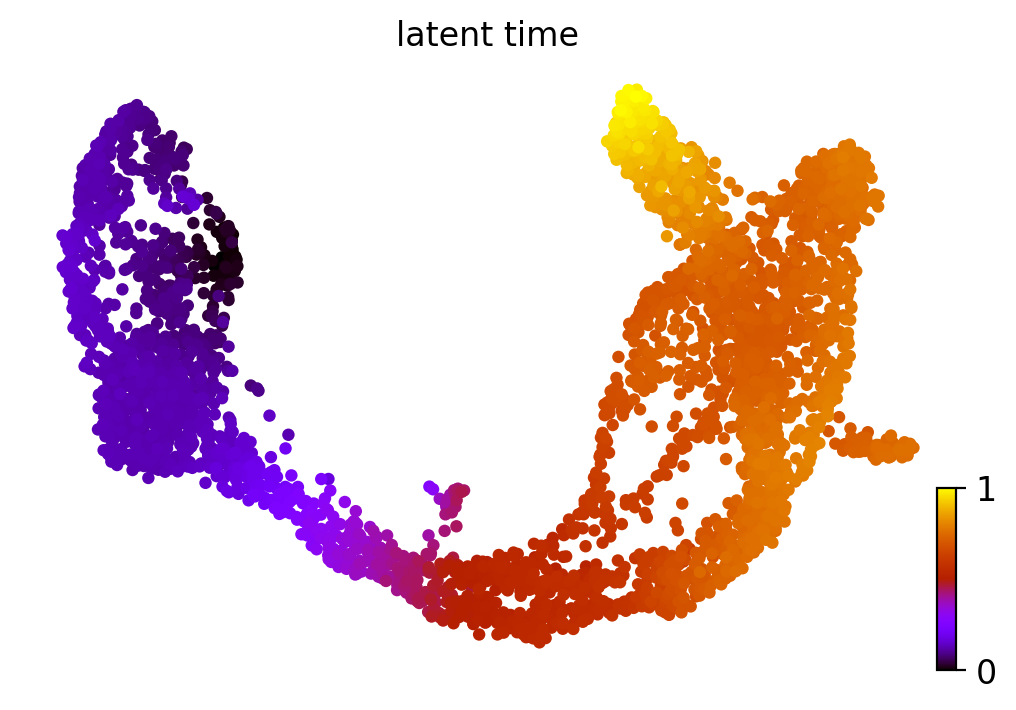

In [39]:
scv.tl.latent_time(test)
scv.pl.scatter(test, color='latent_time', color_map='gnuplot', size=80)